# Bias-Aware Clustering
In this notebook, we experiment with the Bias-Aware Clustering algorithm to identify which of the clustering algorithms (K-Means, DBSCAN or MeanShift) perform best in identifying discriminated clusters. The experiment is conducted on a synthetic dataset. The process of creating this dataset can be found in the "synthetic data" notebook. 

### Init


In [28]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## 1. Importing the Dataset

In [59]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\theoretical_data.csv', index_col=0)
raw_data.index = pd.RangeIndex(start=0, stop=4032, step=1)

# features = raw_data.drop(['errors', 'class'], axis=1)

# errors
# raw_data.loc[raw_data['errors']==1]

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       4032 non-null   float64
 1   y       4032 non-null   float64
 2   errors  4032 non-null   int64  
 3   class   4032 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 126.1 KB


### Utils

In [30]:
def pca_plot(data):
    pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
    other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]

    df = pd.DataFrame(pca_features)
    pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)

    temp_dataset = pca.join(other_features, how='left')
    temp_dataset.rename( columns={0 :'1st'}, inplace=True )
    temp_dataset.rename( columns={1 :'2nd'}, inplace=True )
    
    scatterplot = sns.scatterplot(data=temp_dataset, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
    """Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8 

    if just_features:
        new_data = new_data.drop(['errors', 'class'], axis=1)

    if scale_features:
        to_scale = raw_data.drop(['errors', 'class'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_random_cluster(clusters):
    """This function returns the value of a random cluster
    clusters Df.Column the column clusters"""
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    return result

def plot_clusters(data):
    """This function returns a scatterplot of the clusters"""    
    scatterplot = sns.scatterplot(data=data, x='x', y='y', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    """This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" """ 
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    """ This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors" """
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    """ This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    """ This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters"""
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_abs_bias_cluster(fulldata, function=bias_acc):
    """ This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = function(fulldata, cluster_number, "clusters") # abs function
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    return best_cluster

def calculate_variance(data):
    """This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg"""
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    """Returns the size of the smallest new cluster"""
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

## 1. Bias-Aware KMeans Clustering 

In [32]:
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}

In [61]:
full_data = initialize_dataset(raw_data)
full_data.index = pd.RangeIndex(start=0, stop=4032, step=1)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              4032 non-null   float64
 1   y              4032 non-null   float64
 2   scaled_errors  4032 non-null   float64
 3   errors         4032 non-null   int64  
 4   clusters       4032 non-null   int64  
 5   new_clusters   4032 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 189.1 KB


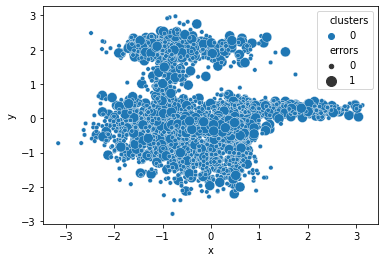

average_accuracy is:  0.7351190476190477


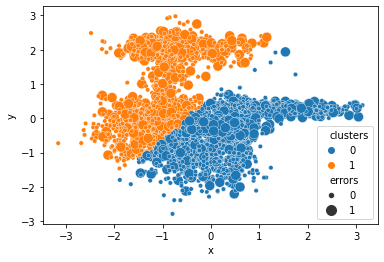

--> Cluster with the highest variance: 1


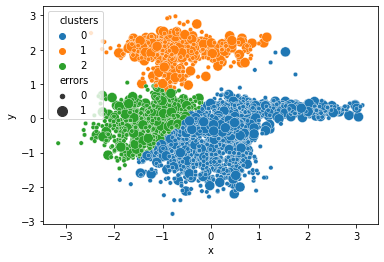

--> Cluster with the highest variance: 1


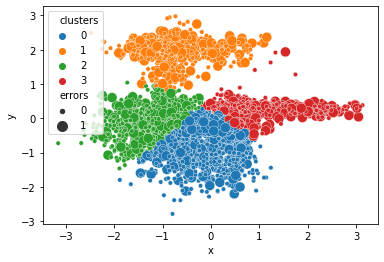

--> Cluster with the highest variance: 1


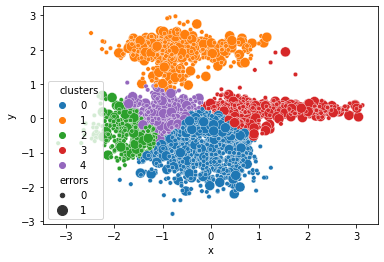

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4


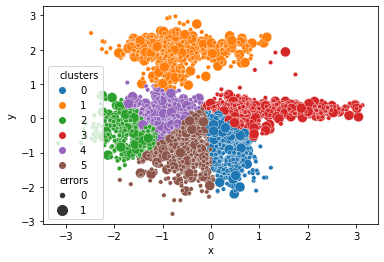

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4


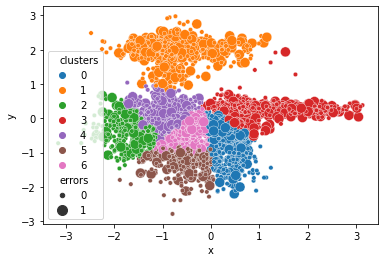

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6


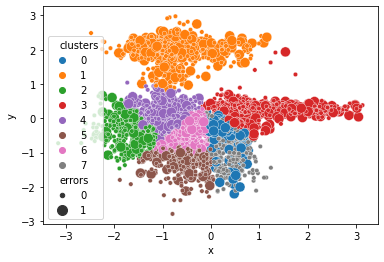

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6


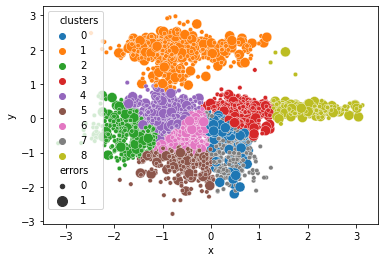

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6


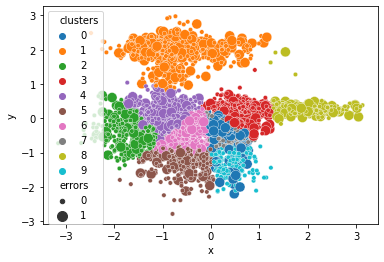

--> Cluster with the highest variance: 1
--> Cluster with the highest variance: 4
--> Cluster with the highest variance: 6
MAX_ITER is reached
[0.003902562068697397, 0.00381734289859063, 0.00381734289859063, 0.005334774787408913, 0.005334774787408913, 0.009715716561820234, 0.009715716561820234, 0.009715716561820234, 0.009715716561820234, 0.008084390810762494, 0.008084390810762494, 0.008084390810762494, 0.008084390810762494, 0.008084390810762494, 0.012433997310798738, 0.012433997310798738, 0.09866518379330529, 0.09866518379330529, 0.09866518379330529, 0.09866518379330529, 0.0892306745191765, 0.0892306745191765, 0.0892306745191765, 0.0892306745191765, 0.0892306745191765, 0.0892306745191765, 0.08883856051822561, 0.08883856051822561]


In [62]:
MAX_ITER = 30
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.05 * len(full_data))
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_neg_bias = get_max_negative_bias(full_data) # was get_max_abs_bias, but now it only finds the discriminated clusters
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_neg_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #abs: >
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_neg_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER is reached')
print(variance_list)


### 1. Analysing the clustering results


In [63]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest negative bias")
print(most_biased_cluster_kmeans_aware)

1 has bias -0.08882342066770066
4 has bias -0.12948678317505735
6 has bias -0.15969300619701754
2 has bias 0.1040360233238572
5 has bias 0.11750699669020714
7 has bias 0.29196282121377803
9 has bias 0.2910874897792314
0 has bias -0.7942122186495176
3 has bias 0.13066186640694644
8 has bias 0.02098859315589363
General accuracy of classifier on this dataset: 0.7351190476190477
cluster 0 has the highest negative bias
-0.7942122186495176


Text(0.5, 1.0, 'Negative Bias Variance of Instances')

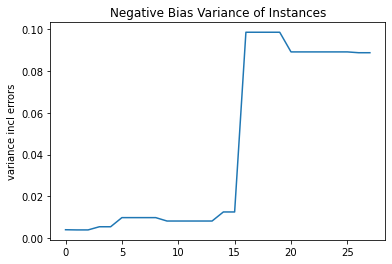

In [64]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance incl errors").set_title('Negative Bias Variance of Instances')

In [65]:
discriminated_cluster = full_data[full_data['clusters']==c]
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
discriminated_cluster

Number of instances in discriminated cluster: 300
Number of errors in discriminated clusters:  300


x         y  scaled_errors  errors  clusters  new_clusters
409  -0.091105  0.169428            0.8       1         0          -1.0
593   0.043659 -1.124954            0.8       1         0          -1.0
600   0.580448 -0.980953            0.8       1         0          -1.0
601   0.647812 -0.561779            0.8       1         0          -1.0
603   0.554836 -0.614757            0.8       1         0          -1.0
...        ...       ...            ...     ...       ...           ...
3860  0.202565 -0.187227            0.8       1         0          -1.0
3861 -0.003460 -0.207344            0.8       1         0          -1.0
3862  0.053981 -0.183066            0.8       1         0          -1.0
3863  0.056552 -0.368394            0.8       1         0          -1.0
3864  0.299477 -0.274641            0.8       1         0          -1.0

[300 rows x 6 columns]

## Baseline KMeans

In [69]:
full_data = initialize_dataset(raw_data)
full_data.head()

x         y  scaled_errors  errors  clusters  new_clusters
0 -1.220665  2.063892            0.0       0         0            -1
1 -1.435781  1.692252            0.0       0         0            -1
2 -0.458579  1.827157            0.0       0         0            -1
3 -1.521471  2.036667            0.8       1         0            -1
4 -1.206578  2.001790            0.8       1         0            -1

In [70]:
# Same number of clusters as the found clusters by the bias-aware clustering algorithm?
baseline_kmeans = KMeans(n_clusters=9, init="k-means++", n_init=10, max_iter=300, random_state=10).fit(full_data.drop(['clusters', 'new_clusters', 'errors'], axis=1))
full_data['clusters'] = pd.DataFrame(baseline_kmeans.predict(full_data.drop(['clusters', 'new_clusters','errors'], axis=1)),index=full_data.index) 


In [71]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinekm = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinekm)

6 has bias -0.08704008300761101
2 has bias -0.06340522954572847
4 has bias -0.14937933126162928
7 has bias 0.08552631578947367
0 has bias 0.060637038283115174
5 has bias 0.26269464889239513
1 has bias 0.32357558940575604
3 has bias -0.8183324130314743
8 has bias 0.02977548821350018
cluster 3 has the highest negative bias
[6 2 4 7 0 5 1 3 8]
Overall accuracy: 0.7351190476190477
Highest found negative bias: -0.8183324130314743


# 2. Bias-Aware DBSCAN

In [72]:
from sklearn.cluster import DBSCAN

In [94]:
full_data = initialize_dataset(raw_data)
full_data.index = pd.RangeIndex(start=0, stop=4032, step=1)

nn_features = full_data[['x', 'y', 'scaled_errors']]
nn_features.head()

x         y  scaled_errors
0 -1.220665  2.063892            0.0
1 -1.435781  1.692252            0.0
2 -0.458579  1.827157            0.0
3 -1.521471  2.036667            0.8
4 -1.206578  2.001790            0.8

In [86]:
from sklearn.neighbors import NearestNeighbors


In [91]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(nn_features)
distances, indices = nbrs.kneighbors(nn_features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

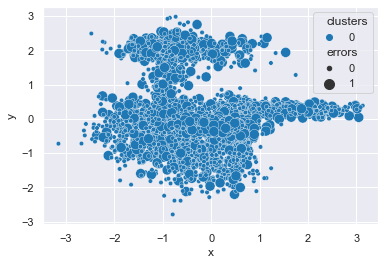

this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  1
this is the current cluster:  0
this is the current cluster:  1
this is the current cluster:  0
MAX_ITER
[]


In [95]:
MAX_ITER = 30 #should be increased, but then I should increase all the max iterations for all bias-aware algorithms
epsilon = 0.15
minimum_samples = 6 # 2*dim
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.05 * len(full_data))
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    print('this is the current cluster: ', x)
    epsilon = epsilon - 0.001
    if len(full_data['clusters'].unique()) != 1:
        variance_list.append(calculate_variance(full_data))

    full_data['new_clusters'] = -2
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): #>
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        # print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif (clstr == -2):
                continue
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1

        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 2. DBSCAN Results

In [96]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_dbscan_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_dbscan_aware)

This cluster is the entire dataset. cluster  0
You are calculating the accuracy on a empty cluster


ZeroDivisionError: division by zero

<AxesSubplot:ylabel='variance excl errors'>

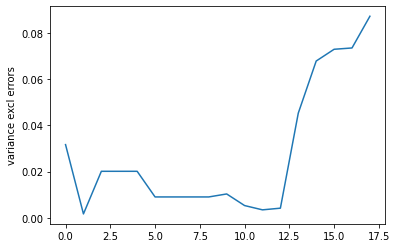

In [17]:
variance_df_dbscan = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df_dbscan, x=variance_df_dbscan.index,y="variance excl errors")

## DBSCAN Baseline

In [18]:
full_data = initialize_dataset(raw_data)

[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0  1 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1]
[ 0 -1  1  2]
[ 0 -1  1  2]
[ 0 -1  1  2]
[ 0 -1  1  2]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  6  5]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  7  6]
[-1  0  1  2  3  4  5  8  9  

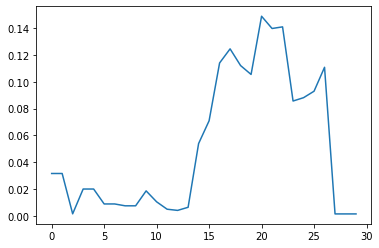

In [19]:
var_list = []
epsilon = 7
minimum_samples = 3
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.2
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
# print(var_list)

plt.plot(var_list)

## 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [36]:
from sklearn.cluster import MeanShift, estimate_bandwidth 
# full_data = initialize_dataset(raw_data)
full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

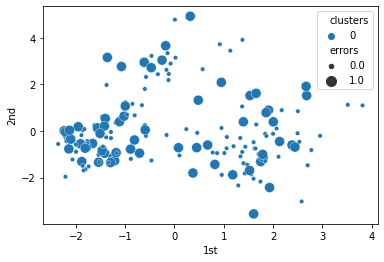

average_accuracy is:  0.6272189349112426
smallest cluster: 75
CHECK!


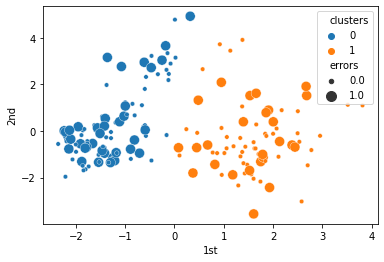

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


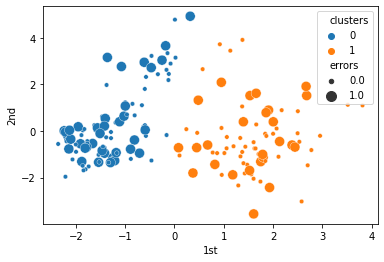

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


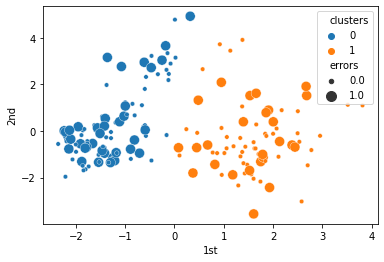

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


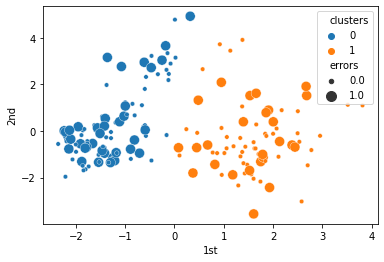

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


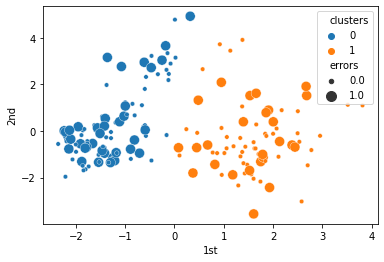

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


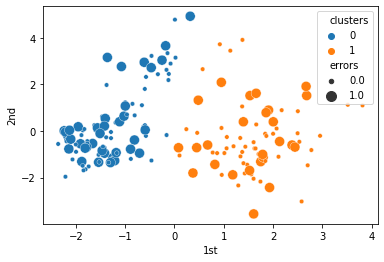

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


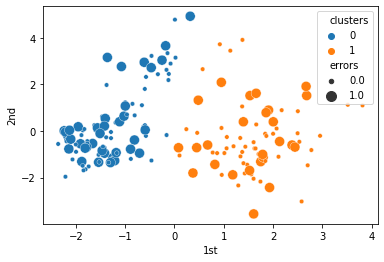

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


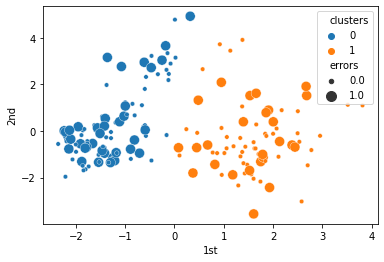

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


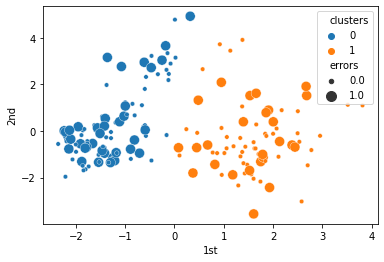

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


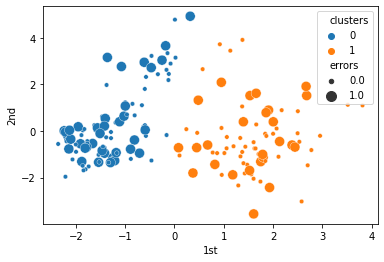

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


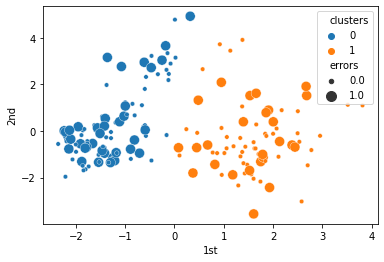

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


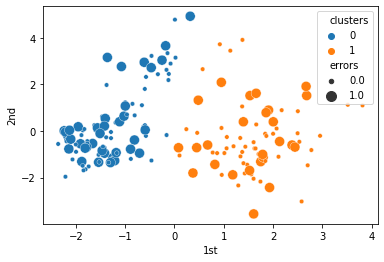

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


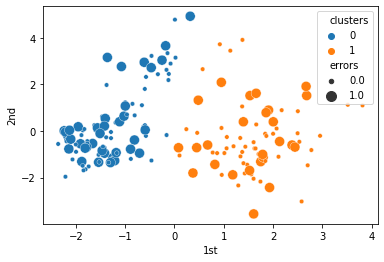

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


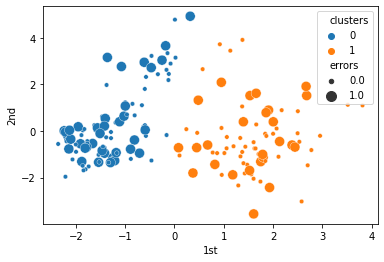

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


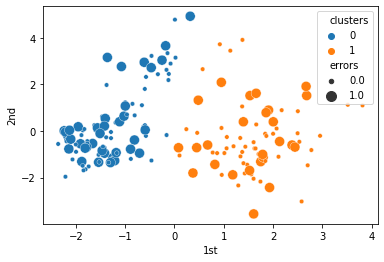

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


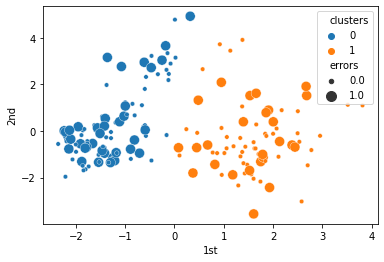

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


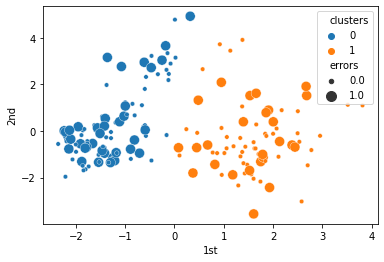

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


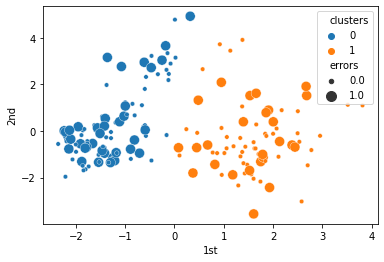

--> Cluster with the highest variance: 0
smallest cluster: 94
CHECK!


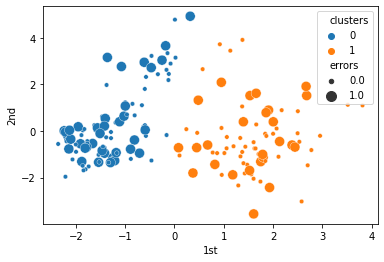

--> Cluster with the highest variance: 0
MAX_ITER
[0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568, 0.005029928072028568]


In [37]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
# bw1 = 1.5
bw1 = estimate_bandwidth(full_data)
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 5
minimal_acceptable_cluster_size = 0
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_abs_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        print("CHECK!")
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

In [38]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_meanshift_aware = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_meanshift_aware)

0 has bias -0.07092198581560283
1 has bias 0.07092198581560283
cluster 0 has the highest negative bias
[0 1]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.07092198581560283


<AxesSubplot:ylabel='variance incl errors'>

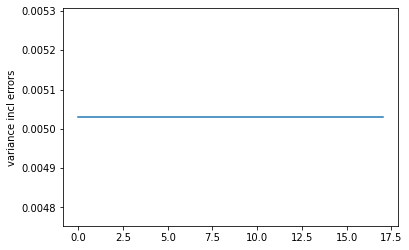

In [39]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance incl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance incl errors")

## Baseline Mean Shift

In [40]:
# full_data = initialize_dataset(raw_data)

full_data = raw_data.copy(deep=True)
full_data.head()

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

In [41]:
bw1 = estimate_bandwidth(full_data)

full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=full_data.index)

In [42]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

0 has bias -0.07092198581560283
1 has bias 0.07092198581560283
cluster 0 has the highest negative bias
[0 1]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.07092198581560283


## Goal 1: Comparing Bias-Aware KMeans/DBSCAN/MeanShift with finding the highest negatively biased cluster

<BarContainer object of 5 artists>

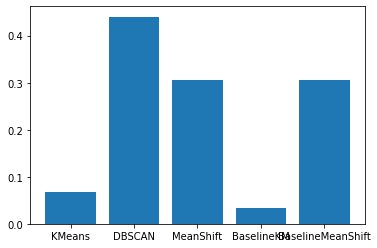

In [33]:
results_array = []

# the minus is to make the values positive, as that makes it easier to find the highest negative biased cluster
results_array.append(-most_biased_cluster_kmeans_aware)
results_array.append(-most_biased_cluster_dbscan_aware)
results_array.append(-most_biased_cluster_meanshift_aware)
results_array.append(-most_biased_cluster_baselinekm)
results_array.append(-most_biased_cluster_baselinemeanshift)


plt.bar(['KMeans', 'DBSCAN', 'MeanShift', 'BaselineKM', 'BaselineMeanShift'], results_array)
# todo: add baselines


In [47]:
full_data = raw_data.copy(deep=True)
full_data.head()

# full_data = initialize_dataset(raw_data)

1st       2nd  scaled_errors  predicted_class  true_class  errors  \
136 -1.468126  0.624496            0.0                0         0.0     0.0   
76  -1.417878 -0.950103            0.3                0         1.0     1.0   
280 -0.078468  2.895461            0.0                0         0.0     0.0   
319 -1.625901  0.254482            0.0                0         0.0     0.0   
174 -1.660360 -0.534133            0.3                0         1.0     1.0   

     clusters  new_clusters  
136         0            -1  
76          0            -1  
280         0            -1  
319         0            -1  
174         0            -1

One cluster left on iteration  2
With epsilon 6.8
[]


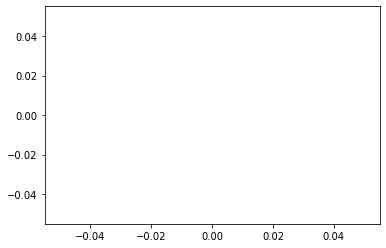

In [48]:
var_list = []
epsilon = 7
minimum_samples = 3
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.2
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
print(var_list)

plt.plot(var_list)

## MeanShift without recursivity

In [36]:
full_data = initialize_dataset(raw_data)

In [37]:
bw1 = estimate_bandwidth(full_data)

full_data['clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(full_data.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=full_data.index)

In [38]:
# Goal 1: Identifying highest biased cluster
c = get_max_abs_bias_cluster(full_data)
print(f"cluster {c} has the highest negative bias")
print(full_data['clusters'].unique())
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
print('Overall accuracy:', accuracy_full_data)

most_biased_cluster_baselinemeanshift = bias_acc(full_data, c, 'clusters')

full_data[full_data['clusters']==c]
print('Highest found negative bias:', most_biased_cluster_baselinemeanshift)

0 has bias 0.08745684695051792
1 has bias -0.3047034764826176
3 has bias 0.375
4 has bias 0.375
2 has bias -0.12874251497005984
5 has bias 0.375
cluster 1 has the highest negative bias
[0 1 3 4 2 5]
Overall accuracy: 0.6272189349112426
Highest found negative bias: -0.3047034764826176


In [ ]:
var_list = []

# experimenting with the bandwidth parameter
bw1 = estimate_bandwidth(features_i)
bw2 = None
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = MeanShift(bandwidth=bw1).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)
    #features['cluster_results'] = pd.DataFrame(DBSCAN.predict(features_i), index=features.index)
    neg_bias_list = []
    if  len(features_i["cluster_results"].unique()) == 1:
        # print("One cluster left on iteration ", n)
        break
    for i in features_i["cluster_results"].unique():
        # print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
# print(var_list)



In [97]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired', s=1.1)
    plt.title("DBSCAN")

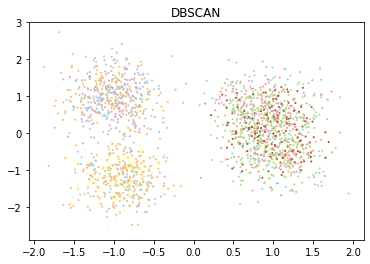

In [101]:
dbscan(synthetic, 1, 100)

In [94]:
def kmeans(X, n_clusters):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred = km.predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired', s=0.9)
    plt.title("K-means")

## Dimensionality Reduction
